In [22]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from RaTag.scripts.wfm2read_fast import wfm2read
from scipy.signal import find_peaks

In [51]:
trigger_file = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/sca_waveform.wfm'
trig = wfm2read(trigger_file)
trig_x, trig_y = trig[1], trig[0]
trig_y = trig_y / (2* np.max(trig_y))

path = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/*.wfm'
files = glob(path)

Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/sca_waveform.wfm starting at index 0 with step 1


Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_1Wfm.wfm starting at index 0 with step 1
Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_11Wfm.wfm starting at index 0 with step 1
Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_13Wfm.wfm starting at index 0 with step 1
Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_3Wfm.wfm starting at index 0 with step 1
Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/w

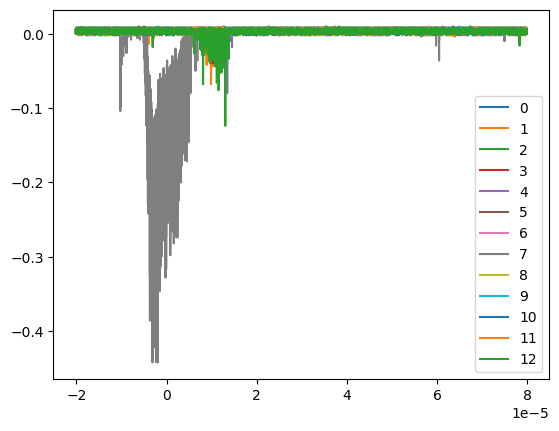

In [18]:
for i,f in enumerate(files):
    wf = wfm2read(f)
    x, y = wf[1], wf[0]
    plt.plot(x, y, label=i)
plt.legend()
# plt.gca().set(xlim=(0.75e-5, 2e-5))

Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_10Wfm.wfm starting at index 0 with step 1


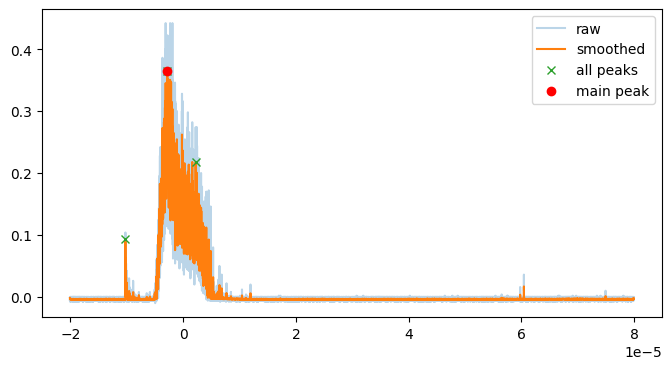

In [60]:
# …existing code…
file7 = files[7]
wf     = wfm2read(file7)
x, y   = wf[1], -wf[0]

# 1) smooth with a simple moving average
window   = 50
kernel   = np.ones(window) / window
y_smooth = np.convolve(y, kernel, mode='same')

# 2) find all peaks in the smoothed trace
peaks, props = find_peaks(
    y_smooth,
    height=np.max(y_smooth)*0.2,
    distance= len(x) / 20,
)

# 3) select the main (highest) peak
main_peak = peaks[np.argmax(props['peak_heights'])]

# 4) plot raw, smoothed, all peaks and main peak
plt.figure(figsize=(8,4))
plt.plot(x, y,        alpha=0.3, label='raw')
plt.plot(x, y_smooth,           label='smoothed')
plt.plot(x[peaks],   y_smooth[peaks], 'x', label='all peaks')
plt.plot(x[main_peak], y_smooth[main_peak], 'ro', label='main peak')
plt.legend()
# …existing code…

Rise time (10→90%): 7142.06 ns


Text(-3.118569696969698e-06, 0.3276400105446577, '90%')

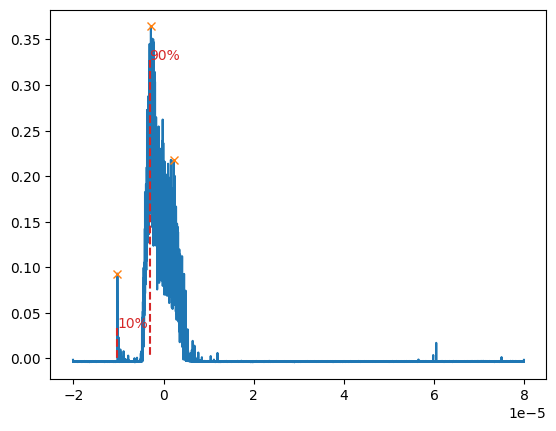

In [64]:
# calculate 10–90% rise time
baseline   = np.median(y_smooth[:main_peak])       # or np.min if you prefer
peak_value = y_smooth[main_peak]

thr10 = baseline + 0.1*(peak_value - baseline)
thr90 = baseline + 0.9*(peak_value - baseline)

# take only the rising segment up to the peak
rseg = y_smooth[:main_peak+1]
xseg = x[:main_peak+1]

# find first indices above each threshold
i10 = np.where(rseg >= thr10)[0][0]
i90 = np.where(rseg >= thr90)[0][0]

# linear interp for more accurate crossing time
t10 = np.interp(thr10, [rseg[i10-1], rseg[i10]], [xseg[i10-1], xseg[i10]])
t90 = np.interp(thr90, [rseg[i90-1], rseg[i90]], [xseg[i90-1], xseg[i90]])

rise_time = t90 - t10
print(f"Rise time (10→90%): {rise_time*1e9:.2f} ns")

plt.plot(x, y_smooth,           label='smoothed')
plt.plot(x[peaks],   y_smooth[peaks], 'x', label='all peaks')

# optional: annotate on your plot
plt.vlines([t10, t90], [thr10, thr90], [0.0, 0.0], linestyles='--', colors='C3')
plt.text(t10, thr10,  '10%', color='C3')
plt.text(t90, thr90,  '90%', color='C3')

In [82]:
cond1 = peaks[0] < main_peak
x_s1 = x[peaks[0]] if cond1 else None
x_s2 = x[main_peak] if cond1 else None
drift_time = x[main_peak] - x[peaks[0]] if cond1 else None
print(f"Drift time: {drift_time*1e9:.2f} ns")

Drift time: 7430.20 ns


Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_10Wfm.wfm starting at index 0 with step 1


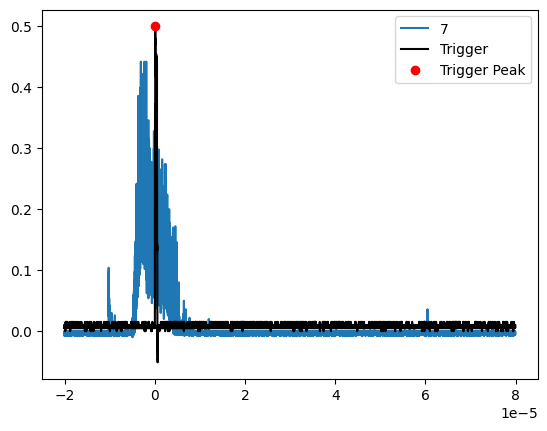

In [75]:
file7 = files[7]
wf = wfm2read(file7)
x, y = wf[1], -wf[0]
plt.plot(x, y, label=7)
plt.plot(trig_x, trig_y, label='Trigger', color='black')
peak_trig = np.argmax(trig_y)
plt.plot(trig_x[peak_trig], trig_y[peak_trig], 'ro', label='Trigger Peak')

plt.legend()

In [83]:
cond2 = peaks[0] < peak_trig
trigger_delay = trig_x[peak_trig] - x_s1 if cond2 else None
s2_amp = y[main_peak] if cond1 and cond2 else None
s1_amp = y[peaks[0]] if cond1 and cond2 else None
print(f"Trigger delay: {trigger_delay*1e9:.2f} ns")

Trigger delay: 10332.80 ns
